In [22]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, hamming_loss,
                             multilabel_confusion_matrix)

In [23]:
root_dir = Path('.')  # Or specify the full path if needed

# List all directories starting with "results_MIL_with_weights_"
result_dirs = sorted(root_dir.glob('results_distilbert_attention_*'), key=lambda x: x.name, reverse=True)

# Ensure there's at least one directory
if result_dirs:
    # Get the latest directory
    latest_dir = result_dirs[0]
    
    # Define the path to the CSV file
    csv_path = latest_dir / 'dev_predictions.csv'
    
    # Load the CSV file
    if csv_path.exists():
        predictions_df = pd.read_csv(csv_path)
        print("File retrieved:", csv_path)
        print(predictions_df.head())
    else:
        print(f"The CSV file does not exist in {latest_dir}")
else:
    print("No result directories found.")

emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]

File retrieved: results_multi_head_attention_2025-02-04_15-08-44/dev_predictions.csv
                      id                                               text  \
0  eng_dev_track_a_00001  Older sister (23 at the time) is a Scumbag Stacy.   
1  eng_dev_track_a_00002  And I laughed like this: garhahagar, because m...   
2  eng_dev_track_a_00003  It overflowed and brown shitty diarrhea water ...   
3  eng_dev_track_a_00004                           Its very dark and foggy.   
4  eng_dev_track_a_00005  Then she tried to, like, have sex with/strangl...   

   anger  fear  joy  sadness  surprise  pred_anger  pred_fear  pred_joy  \
0      1     0    0        0         0           0          0         1   
1      0     1    0        0         0           1          0         1   
2      1     1    0        1         1           1          1         0   
3      0     1    0        0         0           0          1         0   
4      1     1    0        0         1           1          1    

In [24]:
# manual
# csv_path = 'results/validation_predictions.csv'

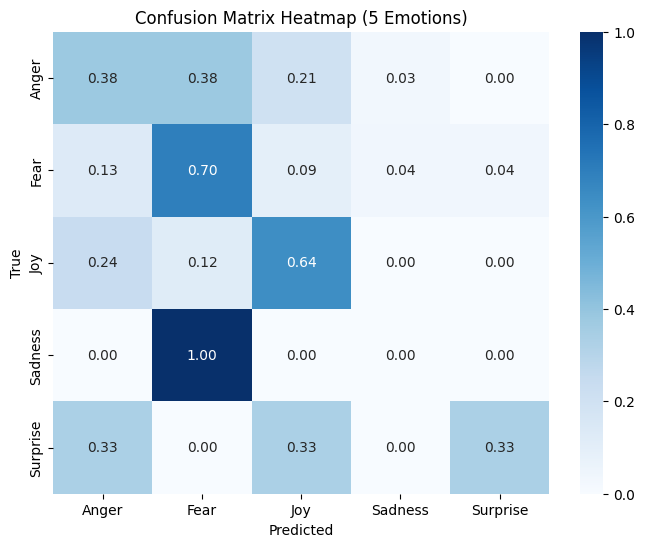

In [25]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# TODO: how to calculate for multi-class?
true_classes = true_labels.argmax(axis=1)
pred_classes = pred_labels.argmax(axis=1)

cm = confusion_matrix(true_classes, pred_classes, labels=range(len(emotion_labels)))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=emotion_labels, 
    yticklabels=emotion_labels
)
plt.title("Confusion Matrix Heatmap (5 Emotions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

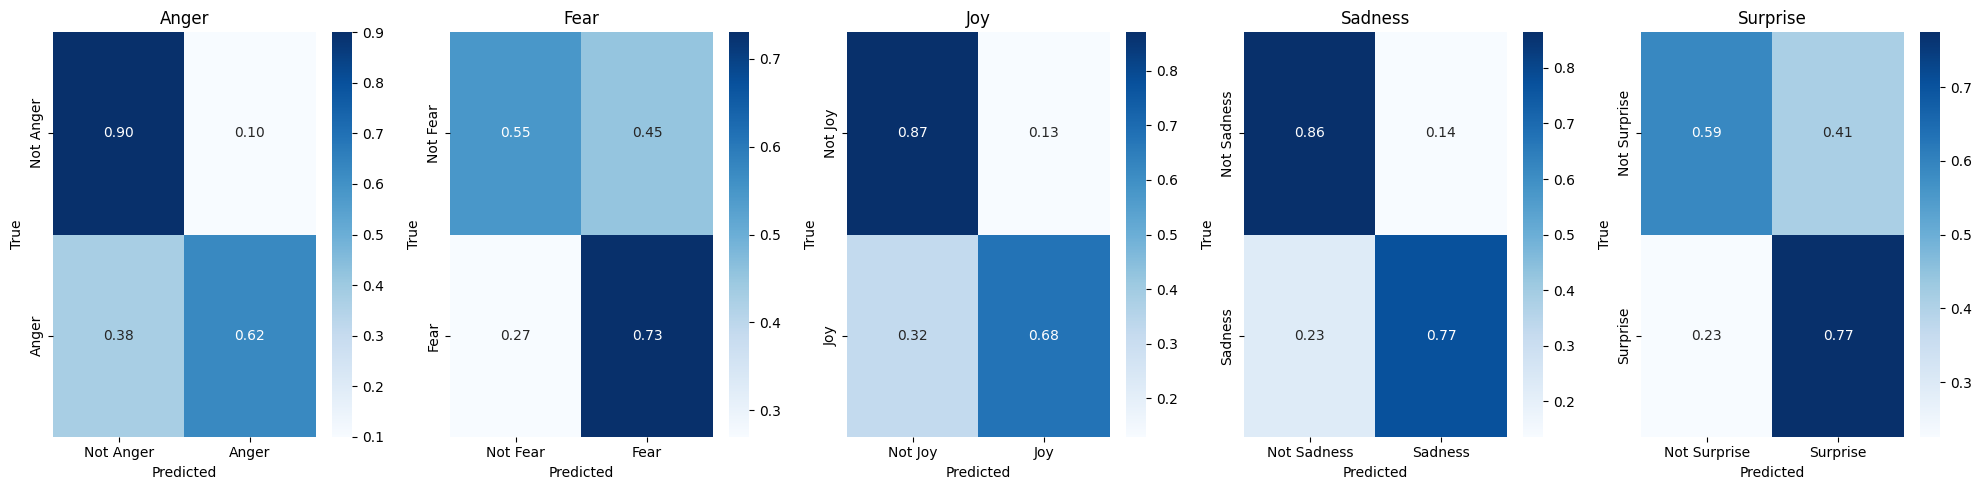

Hamming Loss: 0.2396551724137931
Subset Accuracy: 0.27586206896551724


In [26]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# Multilabel confusion matrix
cm_per_class = multilabel_confusion_matrix(true_labels, pred_labels)

# Normalize confusion matrices to range 0 to 1
cm_per_class_normalized = []
for cm in cm_per_class:
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0  # Handle division by zero
    cm_per_class_normalized.append(cm_normalized)

# Plot heatmaps for each class
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(20, 5))
for i, label in enumerate(emotion_labels):
    sns.heatmap(
        cm_per_class_normalized[i],
        annot=True,
        fmt=".2f",  # Display normalized values with 2 decimal places
        cmap="Blues",
        xticklabels=["Not " + label, label],
        yticklabels=["Not " + label, label],
        ax=axes[i],
    )
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
plt.tight_layout()
plt.show()

# Calculate and display additional metrics
hamming = hamming_loss(true_labels, pred_labels)
subset_acc = accuracy_score(true_labels, pred_labels)

print("Hamming Loss:", hamming)
print("Subset Accuracy:", subset_acc)


In [27]:
f1_scores = []
print("\nMultilabel Classification Report:")
for i, label in enumerate(emotion_labels):
    report = classification_report(true_labels[:, i], pred_labels[:, i], zero_division=0, output_dict=True)
    f1_s = report["macro avg"]["f1-score"]  # Or "macro avg" if you prefer
    f1_scores.append(f1_s)

# Compute the average F1-score across labels
average_f1 = sum(f1_scores) / len(f1_scores)

print(f"\nAverage F1-score across labels: {average_f1:.4f}")



Multilabel Classification Report:

Average F1-score across labels: 0.7152


In [28]:
# Classification Report
print("\nMultilabel Classification Report:")
for i, label in enumerate(emotion_labels):
    print(f"Label: {label}")
    print(classification_report(true_labels[:, i], pred_labels[:, i], zero_division=0))


Multilabel Classification Report:
Label: Anger
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       100
           1       0.50      0.62      0.56        16

    accuracy                           0.86       116
   macro avg       0.72      0.76      0.74       116
weighted avg       0.88      0.86      0.87       116

Label: Fear
              precision    recall  f1-score   support

           0       0.63      0.55      0.59        53
           1       0.66      0.73      0.69        63

    accuracy                           0.65       116
   macro avg       0.64      0.64      0.64       116
weighted avg       0.64      0.65      0.64       116

Label: Joy
              precision    recall  f1-score   support

           0       0.88      0.87      0.88        85
           1       0.66      0.68      0.67        31

    accuracy                           0.82       116
   macro avg       0.77      0.77      0.77       116
wei

In [29]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, hamming_loss,
                             multilabel_confusion_matrix, f1_score)

In [30]:
# f1 macro avg
f1_macro_avg = f1_score(true_labels, pred_labels, average='macro')

In [31]:
f1_macro_avg

0.6374021812522173

In [32]:
f1_scores = {
    emotion: f1_score(true_labels[:, i], pred_labels[:, i], average="binary")
    for i, emotion in enumerate(emotion_labels)
}

print("F1 Scores by Emotion:")
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score:.2f}")

average_f1 = np.mean(list(f1_scores.values()))
print(f"\nAverage F1 Score: {average_f1:.2f}")

F1 Scores by Emotion:
Anger: 0.56
Fear: 0.69
Joy: 0.67
Sadness: 0.74
Surprise: 0.53

Average F1 Score: 0.64


In [17]:
from sklearn.metrics import f1_score

# Group by 'comment' column
grouped = df.groupby('comment')

# Calculate F1 score with macro average for each group
f1_scores_by_comment = {}
for comment, group in grouped:
    true_labels_group = np.array(group["True Labels"].tolist())
    pred_labels_group = np.array(group["Predicted Labels"].tolist())
    f1_macro = f1_score(true_labels_group, pred_labels_group, average='macro')
    f1_scores_by_comment[comment] = f1_macro

# Print the F1 scores
for comment, score in f1_scores_by_comment.items():
    print(f"Comment: {comment}, F1 Score (Macro Avg): {score:.2f}")

KeyError: 'comment'